# 3D Convoloutional Neural Network for Prediction of Neoadjuvant Therapy Response

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, Flatten, Conv3D, Dropout, MaxPooling3D , BatchNormalization, GlobalAveragePooling3D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.utils.vis_utils import plot_model
import tensorflow_hub as hub
from tensorflow.keras import backend as K 

import keras.preprocessing
from sklearn import preprocessing

from sklearn.model_selection import train_test_split

In [8]:
import pandas as pd
import numpy as np
import collections
from collections import Counter
import random
import datetime
import os

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from scipy import ndimage
import scipy.ndimage as ndi
from scipy.ndimage import zoom

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


pd.set_option('display.max_columns', None)

In [ ]:
print("Is there a GPU available: "),
print(tf.config.list_physical_devices("GPU"))

Is there a GPU available: 
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 2

In [ ]:
dataset = np.load('/content/drive/MyDrive/Datasets/Breast_dataset_neoadjuvant-128-128-60.npy', allow_pickle = True)
print(len(dataset))

In [ ]:
keras.backend.clear_session()

In [ ]:
X=[]
y=[]
for patient in dataset:
    X.append(np.array(patient[0]))
    y.append(np.array(patient[1]))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    random_state=42)

X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [ ]:

train_loader = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_loader = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndi.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

def train_preprocessing(images, labels):
    
    images = tf.cast(images, tf.float32) / 255.
    images = rotate(images)
    images = tf.expand_dims(images, axis=4)

    
    return (images, labels)

def validation_preprocessing(images, labels):
    
    images = tf.cast(images, tf.float32) / 255.
    images = tf.expand_dims(images, axis=4)
    
    return (images, labels)



In [ ]:
train_dataset = (
    train_loader
    .batch(BATCH_SIZE)
    .map(train_preprocessing)
    .prefetch(tf.data.AUTOTUNE)
)

validation_dataset = (
    test_loader
    .batch(BATCH_SIZE)
    .map(validation_preprocessing)
    .prefetch(tf.data.AUTOTUNE)
)

Dimension of the CT scan is: (128, 128, 60, 1)


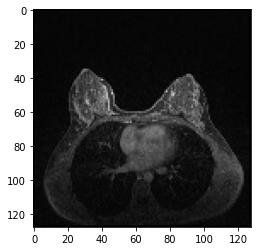

In [ ]:
data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

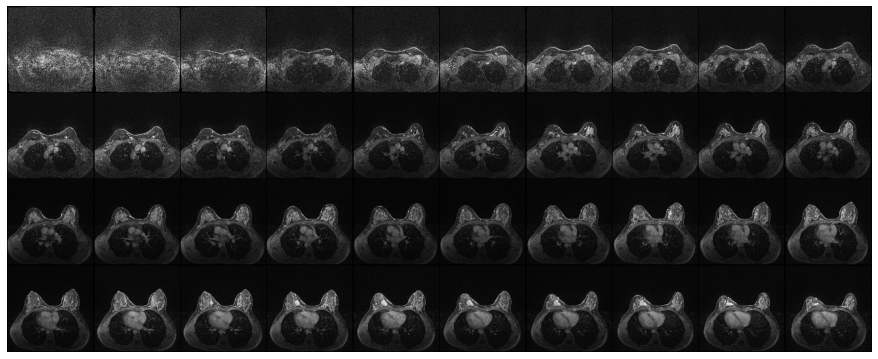

In [ ]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

# Define the Model

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')
]


In [ ]:
def get_model(width=128, height=128, depth=60):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=60)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 60, 1)  0         
                             ]                                   
                                                                 
 conv3d_8 (Conv3D)           (None, 126, 126, 58, 64)  1792      
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 63, 63, 29, 64)   0         
 3D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 63, 63, 29, 64)   256       
 hNormalization)                                                 
                                                                 
 conv3d_9 (Conv3D)           (None, 61, 61, 27, 64)    110656    
                                                             

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=METRICS,
)

# Define callbacks.
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=10)

# Train the model, doing validation at the end of each epoch
epochs = 50
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/50
65/65 - 15s - loss: 0.2919 - tp: 79.0000 - fp: 20.0000 - tn: 73.0000 - fn: 13.0000 - accuracy: 0.8216 - precision: 0.7980 - recall: 0.8587 - auc: 0.8839 - prc: 0.8887 - val_loss: 0.8309 - val_tp: 19.0000 - val_fp: 13.0000 - val_tn: 13.0000 - val_fn: 11.0000 - val_accuracy: 0.5714 - val_precision: 0.5938 - val_recall: 0.6333 - val_auc: 0.5724 - val_prc: 0.5751 - 15s/epoch - 231ms/step
Epoch 2/50
65/65 - 11s - loss: 0.2000 - tp: 59.0000 - fp: 4.0000 - tn: 63.0000 - fn: 3.0000 - accuracy: 0.9457 - precision: 0.9365 - recall: 0.9516 - auc: 0.9939 - prc: 0.9933 - val_loss: 0.8219 - val_tp: 15.0000 - val_fp: 8.0000 - val_tn: 18.0000 - val_fn: 15.0000 - val_accuracy: 0.5893 - val_precision: 0.6522 - val_recall: 0.5000 - val_auc: 0.6333 - val_prc: 0.6189 - 11s/epoch - 176ms/step
Epoch 3/50
65/65 - 11s - loss: 0.1549 - tp: 62.0000 - fp: 2.0000 - tn: 65.0000 - fn: 0.0000e+00 - accuracy: 0.9845 - precision: 0.9688 - recall: 1.0000 - auc: 0.9990 - prc: 0.9990 - val_loss: 1.0811 - val_tp

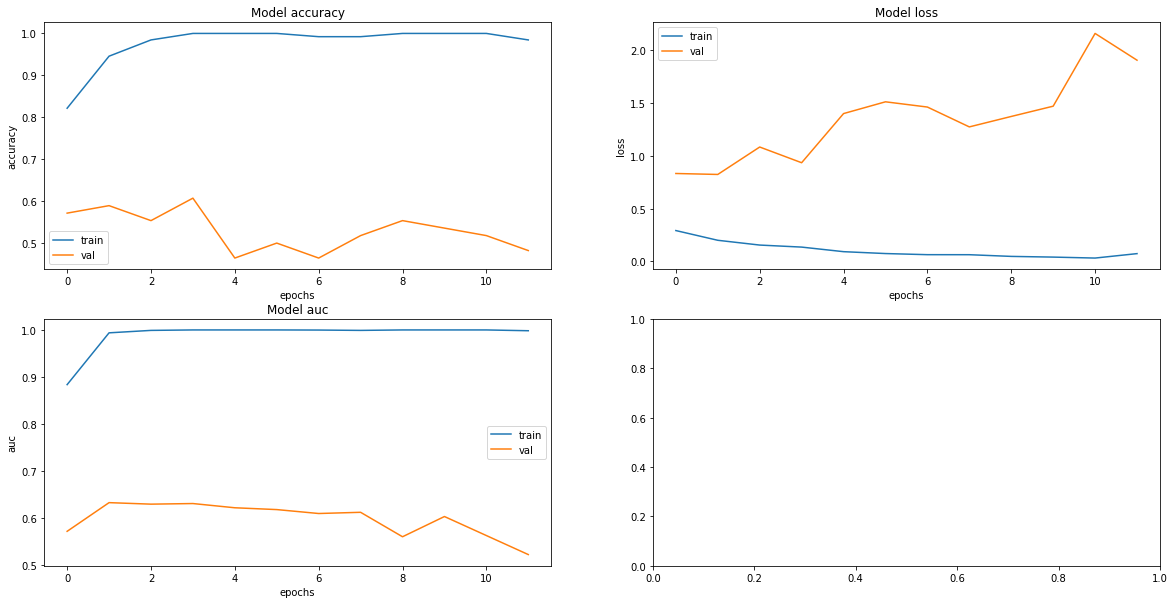

In [ ]:
def plot_metrics(model_history, list_of_metrics):
    
    rows = int(np.ceil(len(list_of_metrics)/2))
    columns = 2
    
    fig, ax = plt.subplots(rows, columns, figsize=(20, 10))
    ax = ax.ravel()

    for i, metric in enumerate(list_of_metrics):
        ax[i].plot(model_history.history[metric])
        ax[i].plot(model_history.history["val_" + metric])
        ax[i].set_title("Model {}".format(metric))
        ax[i].set_xlabel("epochs")
        ax[i].set_ylabel(metric)
        ax[i].legend(["train", "val"])

plot_metrics(model.history, ["accuracy", "loss", "auc"])

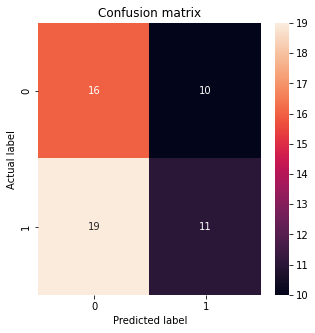

In [ ]:
def plot_cm(labels, predictions, p=0.5):
    
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
test_predictions_baseline = model.predict(validation_dataset, batch_size= BATCH_SIZE)
plot_cm(y_test, test_predictions_baseline)

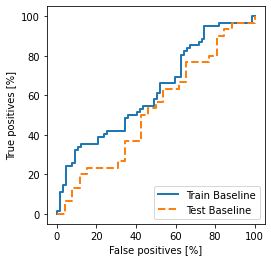

In [ ]:
def plot_roc(name, labels, predictions, **kwargs):
      
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    #plt.xlim([-0.5,20])
    #plt.ylim([80,100.5])
    ax = plt.gca()
    ax.set_aspect('equal')
        
train_predictions_baseline = model.predict(train_dataset, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(validation_dataset, batch_size=BATCH_SIZE)

plot_roc("Train Baseline", y_train, train_predictions_baseline)
plot_roc("Test Baseline", y_test, test_predictions_baseline, linestyle='--')
plt.legend(loc='lower right')

In [ ]:
def print_total_results(model, X_test):
    baseline_results = model.evaluate(X_test,
                                      batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
        print(name, ': ', value)

print_total_results(model, validation_dataset)

loss :  1.9011532068252563
tp :  11.0
fp :  10.0
tn :  16.0
fn :  19.0
accuracy :  0.4821428656578064
precision :  0.523809552192688
recall :  0.36666667461395264
auc :  0.5230768918991089
prc :  0.5490626096725464


this image is 99.90 confident of no response
this image is 0.10 confident of response


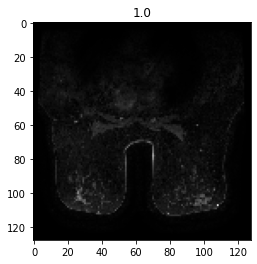

In [ ]:
class_names = ["no response", "response"]

for image, label in validation_dataset.take(1):
    image = image.numpy()
    label = label.numpy()
    image = image[0]
    plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")
    plt.title(str(label[0]))
    
prediction = model.predict(validation_dataset.take(1))[0]
scores = [1- prediction, prediction]


for score,name in zip(scores, class_names):
    print("this image is %.2f confident of %s" % ((100*score), name))